# Gtzan classification using the melspectogram images

In [1]:
#Importing the libraries 

import os
import numpy as np
import pandas as pd
import random
import shutil

import librosa
import matplotlib.pyplot as plt

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print(tf.__version__)

2025-04-18 12:15:25.138316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744978525.343707      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744978525.400474      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


# How melspectogram is generated using librosa 
> (Important features here i learnt are : n_mels,short term forier transform, vmin and vmax range to display the most important sounds)

(661794,)
22050
(1025, 1293)
(256, 1293)
(256, 1293)


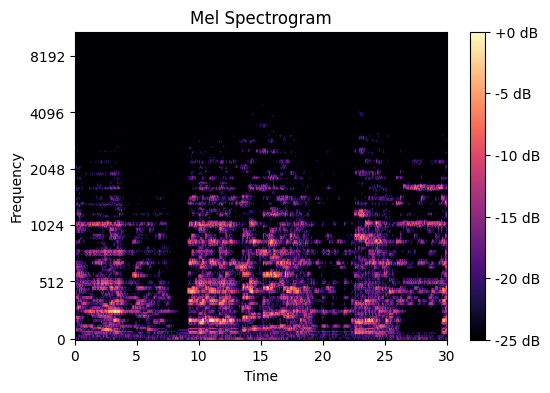

In [2]:
#Librosa functions to see how the melspecs are generated 

audio_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00007.wav'

y, sr = librosa.load(audio_file)
print(y.shape)   #number of frames
print(sr)    #samples per second
D = librosa.stft(y)
print(D.shape)
S = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=256, fmax=8000)

"""
n_mels = 256, you're dividing the spectrum (from 0 Hz to fmax) 
into 256 non-linear frequency bins.
more resolution at low frequencies and vica versa (like ears)
"""

print(S.shape)
S_db = librosa.power_to_db(np.abs(S), ref=np.max) #to db for visualisation
print(S_db.shape)
plt.figure(figsize=(6, 4))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr,vmin=-25,vmax=0)
#O db being the loudest sound and others being relative to that so we will take the values that are most relavant [ref=np.max],np.abs used to handle imaginary values

plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Viewing the Melspec images of various generes
> Tensorflow libraries used here
> * tf.io
> * tf.image

Hiphop
(288, 432, 3)


I0000 00:00:1744978551.144884      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


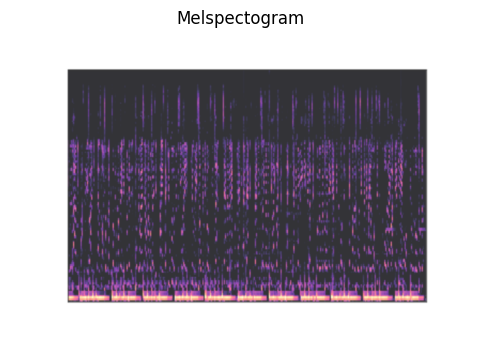

Metal
(288, 432, 3)


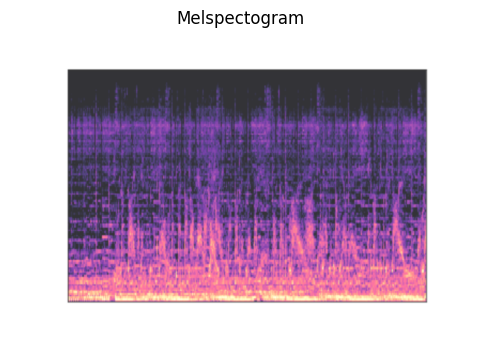

Classical
(288, 432, 3)


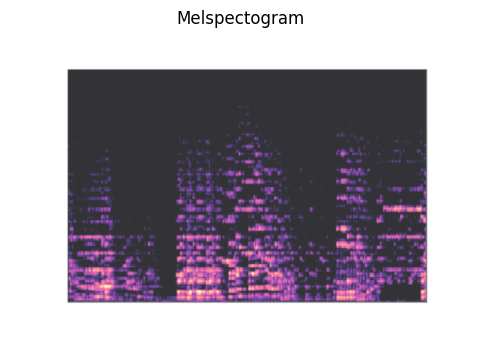

Rock
(288, 432, 3)


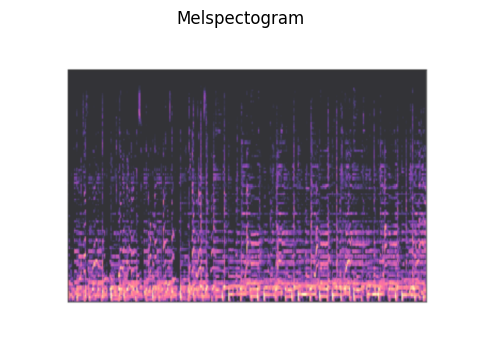

Blues
(288, 432, 3)


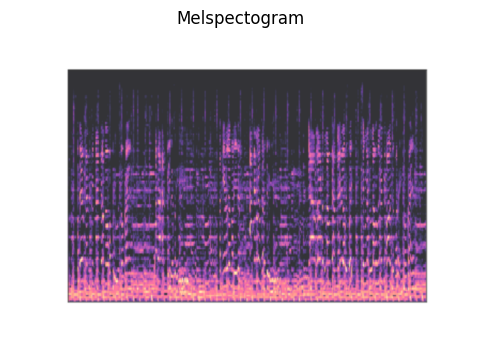

In [3]:
#folder containing subfolders of melspec images
folder_path='/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original'

"""
Melspec spatial features can be visualised through cnn's each genre has different pattern 
of melspec which the model captures and thus can differentiate between music types
"""

total_genres=10

#file path for testing
dictionary={
    "Hiphop":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00001.png',
    "Metal":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/metal/metal00009.png',
    "Classical":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/classical/classical00007.png',
    "Rock":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/rock/rock00010.png',
    "Blues":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00048.png'
    
}

def printing_melspecs(file):
    raw=tf.io.read_file(file)
    image=tf.io.decode_png(raw,channels=3)
    
    print(image.shape)
    #print(image.dtype)
    #print(image)

    image=tf.image.convert_image_dtype(image,tf.float32)
    image=tf.image.adjust_brightness(image,delta=0.2)

    #This not needed as we converted image dtype to adjust brightness
    #image_arr=image.numpy().astype("float32") / 255.0  
    
    image_arr=image.numpy() #(to numpy for visualisation)
    
    plt.figure(figsize=(6,4))
    plt.imshow(image_arr,cmap='cool',interpolation='bicubic')

    plt.axis('off')
    plt.title('Melspectogram')
    plt.show()

for k,v in dictionary.items():
    print(k)
    printing_melspecs(v)

>Notice the difference between melspectograms of different genres,
X axis is time and Y axis is frequency , the colored part represent pitch or amplitude , 
it used Mel scale , similar to how humans perceive audio,(change of frequencies over time)

# {1} Splitting the images from folder into train,test,val sets

In [4]:
base_dir = '/kaggle/working/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

In [5]:
for genre in os.listdir(folder_path):
    genre_folder = os.path.join(folder_path, genre)
    if os.path.isdir(genre_folder):
      
        os.makedirs(os.path.join(train_dir, genre), exist_ok=True)
        os.makedirs(os.path.join(val_dir, genre), exist_ok=True)
        os.makedirs(os.path.join(test_dir, genre), exist_ok=True)

        images = os.listdir(genre_folder)
        random.shuffle(images)

        total_images = len(images)
        train_size = int(total_images * split_ratio['train'])
        val_size = int(total_images * split_ratio['val'])

        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        for image in train_images:
            shutil.copy(os.path.join(genre_folder, image), os.path.join(train_dir, genre, image))
        for image in val_images:
            shutil.copy(os.path.join(genre_folder, image), os.path.join(val_dir, genre, image))
        for image in test_images:
            shutil.copy(os.path.join(genre_folder, image), os.path.join(test_dir,genre,image))

print("Dataset split completed!")

Dataset split completed!


# Image Data Generator and Rescaling function
> Padding/cropping/resizing due to different image dimensions , conv2d expects a consistent input tensor dim.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
IMAGE_SIZE = (128,128)  
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical',
    shuffle=False  
)

Found 699 images belonging to 10 classes.
Found 149 images belonging to 10 classes.
Found 151 images belonging to 10 classes.


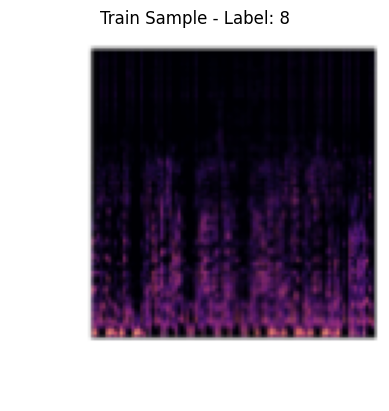

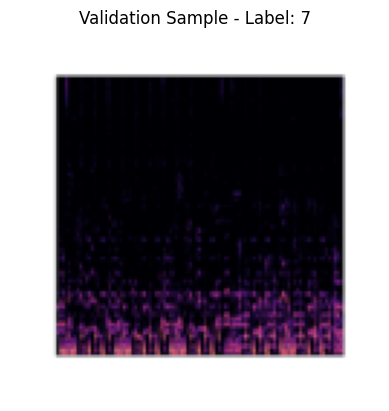

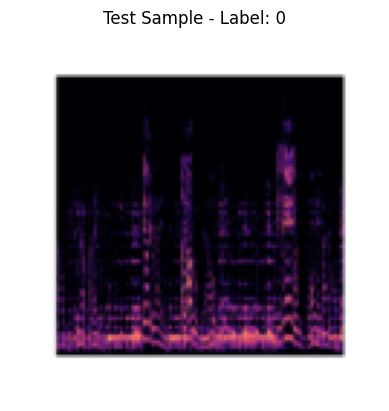

In [9]:
train_batch = next(train_generator)
val_batch = next(val_generator)
test_batch = next(test_generator)

def show_image(img, label, title=""):
    plt.imshow(img)
    plt.title(f"{title} - Label: {label}")
    plt.axis('off')
    plt.show()
    
def denormalize(img):
    return np.clip(img * 255, 0, 255).astype('uint8')

"""
train_batch[0][0] gets the first image in that batch,np argmax gets class index
"""

show_image(denormalize(train_batch[0][0]), np.argmax(train_batch[1][0]), title="Train Sample")
show_image(denormalize(val_batch[0][0]), np.argmax(val_batch[1][0]), title="Validation Sample")
show_image(denormalize(test_batch[0][0]), np.argmax(test_batch[1][0]), title="Test Sample")

> Notice how when we just set image size to 128,128 while resizing it just got kind of distorted, hence we need to apply padding or a mix of resizing and padding  (This is an important step before feeding the data into the neural network)

In [12]:
#Making function for rescale with padding so that data isnt lost 

def rescale(image,target_size=(256,456)):
    h,w,c=image.shape
    t_h,t_w=target_size

    pad_h=max(0,t_h-h)
    pad_w=max(0,t_w-w)

    padded_image=tf.image.resize_with_crop_or_pad(image,h+pad_h,w+pad_w)
    resized_image=tf.image.resize(padded_image,target_size)

    return resized_image

"""
image = tf.io.read_file('/kaggle/working/train/hiphop/hiphop00002.png')
image = tf.io.decode_png(image, channels=3) 
image = tf.image.convert_image_dtype(image, dtype=tf.float32)  

resized_image = rescale(image, target_size=(256, 456))

plt.imshow(resized_image)
plt.title('Padded and Resized Image (256,456)')
plt.axis('off')
plt.show()
"""
#For test

"\nimage = tf.io.read_file('/kaggle/working/train/hiphop/hiphop00002.png')\nimage = tf.io.decode_png(image, channels=3) \nimage = tf.image.convert_image_dtype(image, dtype=tf.float32)  \n\nresized_image = rescale(image, target_size=(256, 456))\n\nplt.imshow(resized_image)\nplt.title('Padded and Resized Image (256,456)')\nplt.axis('off')\nplt.show()\n"

> Now we will apply this function to the while directory and split by that

# {2} Splitting the dataset into train ,test. val sets rescaled and padded 

In [13]:
train_dir = os.path.join(base_dir, 'train_rescaled')
val_dir = os.path.join(base_dir, 'val_rescaled')
test_dir = os.path.join(base_dir, 'test_rescaled')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

def save_rescaled_image(image_path, save_dir):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    resized_img = rescale(img)
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    tf.keras.preprocessing.image.save_img(save_path, resized_img.numpy())

In [14]:
for genre in os.listdir(folder_path):
    genre_folder = os.path.join(folder_path, genre)
    if os.path.isdir(genre_folder):
        os.makedirs(os.path.join(train_dir, genre), exist_ok=True)
        os.makedirs(os.path.join(val_dir, genre), exist_ok=True)
        os.makedirs(os.path.join(test_dir, genre), exist_ok=True)

        images = os.listdir(genre_folder)
        random.shuffle(images)

        total_images = len(images)
        train_size = int(total_images * split_ratio['train'])
        val_size = int(total_images * split_ratio['val'])

        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        for image in train_images:
            image_path = os.path.join(genre_folder, image)
            save_rescaled_image(image_path, os.path.join(train_dir, genre))

        for image in val_images:
            image_path = os.path.join(genre_folder, image)
            save_rescaled_image(image_path, os.path.join(val_dir, genre))

        for image in test_images:
            image_path = os.path.join(genre_folder, image)
            save_rescaled_image(image_path, os.path.join(test_dir, genre))

print("Dataset split and rescaling completed! New folders: train_rescaled, val_rescaled, test_rescaled")

Dataset split and rescaling completed! New folders: train_rescaled, val_rescaled, test_rescaled


In [16]:
IMAGE_SIZE = (256,456)  
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator1 = train_datagen.flow_from_directory(
    '/kaggle/working/train_rescaled',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical'
)

val_generator1 = val_test_datagen.flow_from_directory(
    '/kaggle/working/val_rescaled',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical'
)

test_generator1 = val_test_datagen.flow_from_directory(
    '/kaggle/working/test_rescaled',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    interpolation='bilinear',
    class_mode='categorical',
    shuffle=False  
)

Found 699 images belonging to 10 classes.
Found 149 images belonging to 10 classes.
Found 151 images belonging to 10 classes.


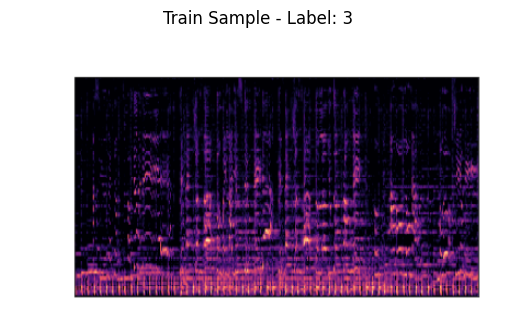

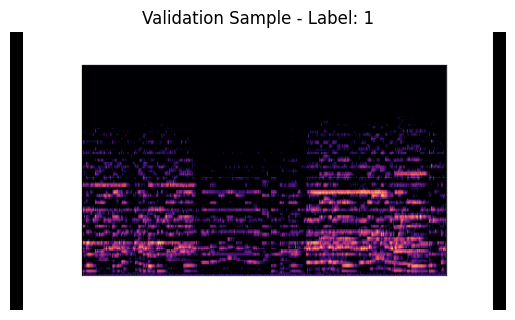

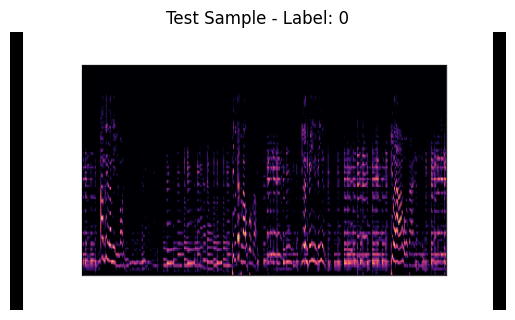

In [17]:
train_batch1 = next(train_generator1)
val_batch1 = next(val_generator1)
test_batch1 = next(test_generator1)

show_image(denormalize(train_batch1[0][0]), np.argmax(train_batch1[1][0]), title="Train Sample")
show_image(denormalize(val_batch1[0][0]), np.argmax(val_batch1[1][0]), title="Validation Sample")
show_image(denormalize(test_batch1[0][0]), np.argmax(test_batch1[1][0]), title="Test Sample")

# Sequential model using Tensorflow Keras 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,GlobalAveragePooling2D,Input,Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model=Sequential([
    
    Input(shape=(256,456,3)),
    
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(10,activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 456, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 456, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 228, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 228, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 228, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 114, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 114, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 114, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 57, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 57, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 57, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 114688)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,680,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,079,434 (57.52 MB)

 Trainable params: 15,078,474 (57.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
"""
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history=model.fit(
    train_generator1,
    epochs=30,
    validation_data=val_generator1,
    callbacks=[early_stop,lr_reduce]
)
"""
#The above code caused underfitting
#Too large melspec images , rescaling to chunks and making size small

"\nearly_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)\nlr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)\n\nhistory=model.fit(\n    train_generator1,\n    epochs=30,\n    validation_data=val_generator1,\n    callbacks=[early_stop,lr_reduce]\n)\n"

In [20]:
genres_original='/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
output_dir='/kaggle/working/melspectograms'
target_shape = (150, 150)
chunk_duration = 4  
overlap_duration = 2  
sr = 22050 
os.makedirs(output_dir, exist_ok=True)

In [22]:
import soundfile as sf
from tqdm import tqdm

def save_melspectrogram(mel_spec, save_path):
    mel_spec = tf.image.resize(mel_spec, target_shape).numpy()
    mel_spec = np.squeeze(mel_spec)  
    plt.imsave(save_path, mel_spec, cmap='gray')

for genre in os.listdir(genres_original):
    genre_path = os.path.join(genres_original, genre)
    if not os.path.isdir(genre_path):
        continue

    print(f"Processing genre: {genre}")
    genre_output_dir = os.path.join(output_dir, genre)
    os.makedirs(genre_output_dir, exist_ok=True)

    for file_name in tqdm(os.listdir(genre_path)):
        if not file_name.endswith('.wav'):
            continue

        file_path = os.path.join(genre_path, file_name)

        try:
            y, _ = librosa.load(file_path, sr=sr)
            chunk_samples = chunk_duration * sr
            overlap_samples = overlap_duration * sr
            step = chunk_samples - overlap_samples
            total_samples = len(y)

            for i in range(0, total_samples - chunk_samples + 1, step):
                chunk = y[i:i + chunk_samples]
                mel = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128)
                mel_db = librosa.power_to_db(mel, ref=np.max)
                mel_db = np.expand_dims(mel_db, axis=-1)

                chunk_id = f"{file_name[:-4]}_chunk{i}.png"
                save_path = os.path.join(genre_output_dir, chunk_id)
                save_melspectrogram(mel_db, save_path)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

Processing genre: disco


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Processing genre: metal


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Processing genre: reggae


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Processing genre: blues


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Processing genre: rock


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Processing genre: classical


100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Processing genre: jazz


 26%|██▌       | 26/100 [00:07<00:20,  3.55it/s]/tmp/ipykernel_31/821952292.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 27%|██▋       | 27/100 [00:07<00:20,  3.64it/s]

Error processing /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Processing genre: hiphop


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Processing genre: country


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Processing genre: pop


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    directory='/kaggle/working/melspectograms',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    directory='/kaggle/working/melspectograms',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 11185 images belonging to 10 classes.
Found 2792 images belonging to 10 classes.


In [28]:
from tensorflow.keras.layers import MaxPool2D
model1 = Sequential([
    Input(shape=(150, 150, 1)), 

    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.3),

    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(256, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(512, kernel_size=3, padding='same', activation='relu'),
    Conv2D(512, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.3),

    Flatten(),
    Dense(1200, activation='relu'),
    Dropout(0.45),
    Dense(10, activation='softmax')  
])

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 57s 126ms/step - accuracy: 0.0996 - loss: 2.3044 - val_accuracy: 0.1003 - val_loss: 2.3027
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.0919 - loss: 2.3030 - val_accuracy: 0.0999 - val_loss: 2.3026
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.0989 - loss: 2.3030 - val_accuracy: 0.1003 - val_loss: 2.3026
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.1051 - loss: 2.3028 - val_accuracy: 0.0999 - val_loss: 2.3026
Epoch 5/30
349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0960 - loss: 2.3028